<a href="https://colab.research.google.com/github/tylerlum/deep_learning_monte_carlo_dropout/blob/main/reduced_dataset_mc_dropout_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Dropout on MNIST

Reference:
https://www.depends-on-the-definition.com/model-uncertainty-in-deep-learning-with-monte-carlo-dropout/#2-selection-by-variance

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

## Setup train/test datasets

In [2]:
batch_size = 128
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Remove 9's from dataset

In [6]:
x_train_removed = x_train[y_train == 9]
x_test_removed = x_test[y_test == 9]

x_train = x_train[y_train != 9]
x_test = x_test[y_test != 9]

y_train_removed = y_train[y_train == 9]
y_test_removed = y_test[y_test == 9]

y_train = y_train[y_train != 9]
y_test = y_test[y_test != 9]

In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (54051, 28, 28, 1)
54051 train samples
8991 test samples


In [8]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
y_train_removed = keras.utils.to_categorical(y_train_removed, num_classes)
y_test_removed = keras.utils.to_categorical(y_test_removed, num_classes)

## Setup regular model and MC model

In [10]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(learning_rate=0.05),
                  metrics=['accuracy'])
    return model

In [11]:
model = get_model(mc=False, act="relu")
mc_model = get_model(mc=True, act="relu")

## Train and evaluate regular model

In [12]:
h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/20
423/423 [==============================] - 3s 6ms/step - loss: 0.7284 - accuracy: 0.7794 - val_loss: 0.2305 - val_accuracy: 0.9334
Epoch 2/20
423/423 [==============================] - 2s 6ms/step - loss: 0.3193 - accuracy: 0.9034 - val_loss: 0.1786 - val_accuracy: 0.9449
Epoch 3/20
423/423 [==============================] - 2s 6ms/step - loss: 0.2697 - accuracy: 0.9192 - val_loss: 0.1505 - val_accuracy: 0.9556
Epoch 4/20
423/423 [==============================] - 2s 6ms/step - loss: 0.2372 - accuracy: 0.9299 - val_loss: 0.1302 - val_accuracy: 0.9616
Epoch 5/20
423/423 [==============================] - 2s 6ms/step - loss: 0.2110 - accuracy: 0.9374 - val_loss: 0.1164 - val_accuracy: 0.9654
Epoch 6/20
423/423 [==============================] - 2s 6ms/step - loss: 0.1925 - accuracy: 0.9415 - val_loss: 0.1034 - val_accuracy: 0.9685
Epoch 7/20
423/423 [==============================] - 2s 6ms/step - loss: 0.1714 - accuracy: 0.9504 - val_loss: 0.0927 - val_accuracy: 0.9726
Epoch 

In [13]:
def plot_train_validation(history, plot_type):
  plt.plot(h.history[plot_type])
  plt.plot(h.history[f'val_{plot_type}'])
  plt.title(f'model {plot_type}')
  plt.ylabel(plot_type)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

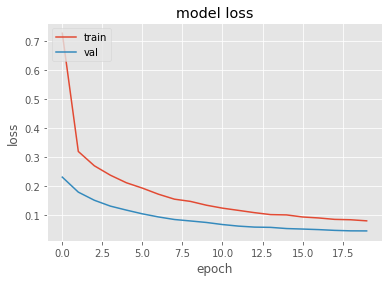

In [14]:
plot_train_validation(h, "loss")

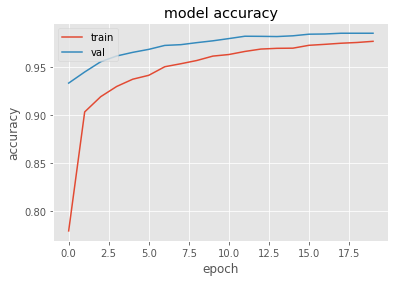

In [15]:
plot_train_validation(h, "accuracy")

In [16]:
print(x_test.shape)
print(y_test.shape)
print(x_test_removed.shape)
print(y_test_removed.shape)

(8991, 28, 28, 1)
(8991, 10)
(1009, 28, 28, 1)
(1009, 10)


In [17]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04434381425380707
Test accuracy: 0.985318660736084


In [18]:
# score of the normal model
score = model.evaluate(x_test_removed, y_test_removed, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 10.979077339172363
Test accuracy: 0.0


In [34]:
layers = [l for l in model.layers]
x = layers[0].output
for i in range(1, len(layers)):
    # Replace dropout layers with MC dropout layers
    if isinstance(layers[i], Dropout):
        x = Dropout(0.2)(x, training=True)
    else:
        x = layers[i](x)
        
mc_model = Model(inputs=layers[0].input, outputs=x)
mc_model.set_weights(model.get_weights())

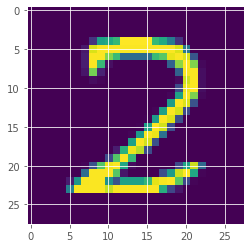

In [35]:
idx = 200
plt.imshow(x_test[idx][:,:,0])

In [36]:
mc_model.predict(np.expand_dims(x_test[idx], axis=0), batch_size=1).argmax()

2

In [37]:
print(f"Ground truth is {y_test[idx].argmax()}")
for i in range(10):
  print(f"Prediction {i} = {mc_model.predict(np.expand_dims(x_test[idx], axis=0), batch_size=1).argmax()}")

Ground truth is 2
Prediction 0 = 2
Prediction 1 = 2
Prediction 2 = 2
Prediction 3 = 2
Prediction 4 = 2
Prediction 5 = 2
Prediction 6 = 2
Prediction 7 = 2
Prediction 8 = 2
Prediction 9 = 2


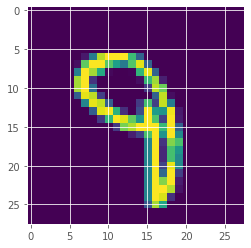

In [38]:
idx = 20
plt.imshow(x_test_removed[idx][:,:,0])

In [39]:
mc_model.predict(np.expand_dims(x_test_removed[idx], axis=0), batch_size=1).argmax()

3

In [40]:
print(f"Ground truth is {y_test_removed[idx].argmax()}")
for i in range(10):
  print(f"Prediction {i} = {mc_model.predict(np.expand_dims(x_test_removed[idx], axis=0), batch_size=1).argmax()}")

Ground truth is 9
Prediction 0 = 4
Prediction 1 = 4
Prediction 2 = 7
Prediction 3 = 4
Prediction 4 = 4
Prediction 5 = 4
Prediction 6 = 4
Prediction 7 = 4
Prediction 8 = 4
Prediction 9 = 7


## Calculate MC Dropout Predictions

In [41]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test_removed, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [00:18<00:00, 26.60it/s]


In [42]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test_removed.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 0.0%


In [43]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test_removed.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 0.0%


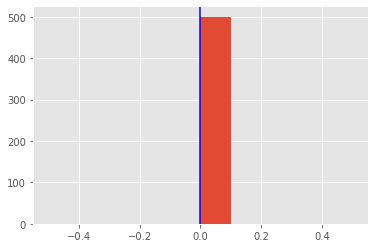

In [44]:
plt.hist(accs)
plt.axvline(x=ensemble_acc, color="b")

## Test MC Dropout results

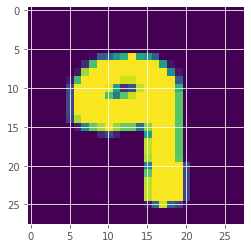

In [45]:
idx = 240
plt.imshow(x_test_removed[idx][:,:,0])

In [46]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test_removed[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 4
true label: 9

class: 0; proba: 0.0%; var: 0.07% 
class: 1; proba: 0.0%; var: 0.05% 
class: 2; proba: 0.0%; var: 0.02% 
class: 3; proba: 0.2%; var: 0.28% 
class: 4; proba: 88.2%; var: 11.26% 
class: 5; proba: 1.3%; var: 2.19% 
class: 6; proba: 0.0%; var: 0.00% 
class: 7; proba: 9.4%; var: 9.69% 
class: 8; proba: 0.9%; var: 2.29% 
class: 9; proba: 0.0%; var: 0.01% 


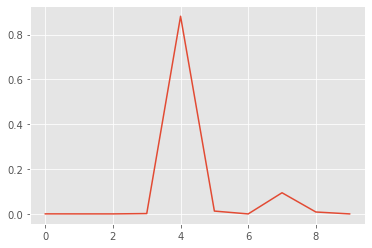

In [47]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

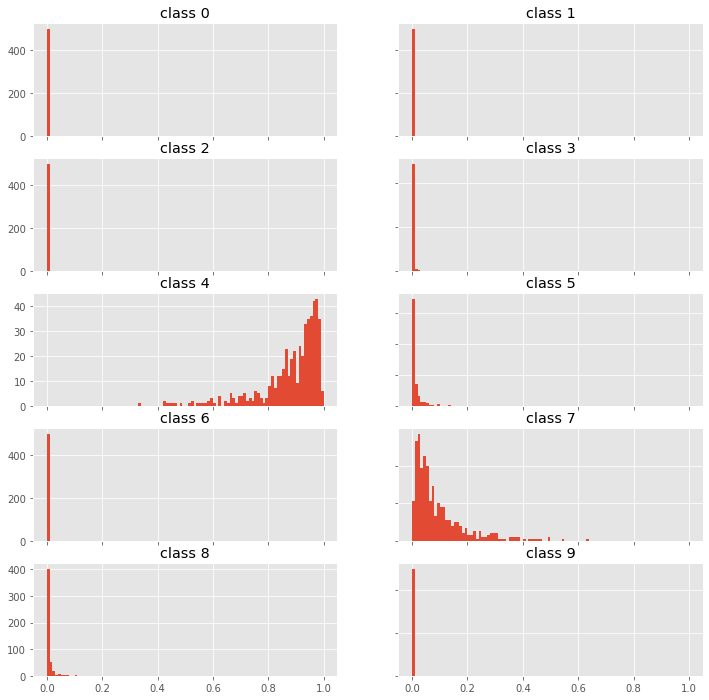

In [48]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

## Test MC dropout on random image

In [49]:
random_img = np.random.random(input_shape)

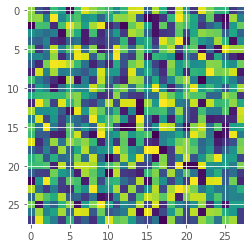

In [50]:
plt.imshow(random_img[:,:,0]);

In [51]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

100%|██████████| 500/500 [00:14<00:00, 34.04it/s]


In [52]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 8

class: 0; proba: 14.0%; var: 5.30% 
class: 1; proba: 5.5%; var: 2.38% 
class: 2; proba: 5.9%; var: 2.68% 
class: 3; proba: 3.5%; var: 1.70% 
class: 4; proba: 18.3%; var: 5.62% 
class: 5; proba: 6.3%; var: 2.30% 
class: 6; proba: 13.4%; var: 6.63% 
class: 7; proba: 9.5%; var: 3.69% 
class: 8; proba: 22.3%; var: 7.70% 
class: 9; proba: 1.3%; var: 0.61% 


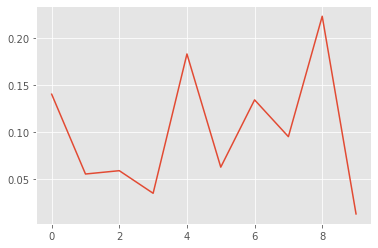

In [53]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

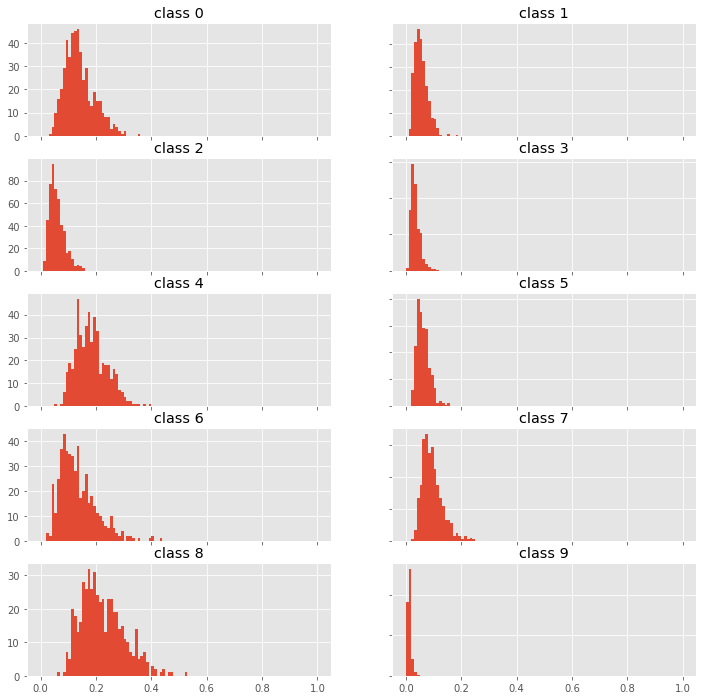

In [54]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

## Test MC dropout on trained image

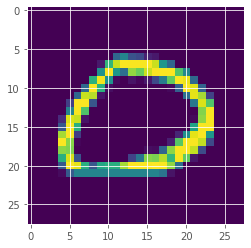

In [55]:
idx = 240
plt.imshow(x_test[idx][:,:,0])

In [57]:
test_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([x_test[idx]]))
    test_predictions.append(y_p)

100%|██████████| 500/500 [00:15<00:00, 33.21it/s]


In [58]:
p0 = np.array([p[0] for p in test_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 0

class: 0; proba: 99.9%; var: 0.33% 
class: 1; proba: 0.0%; var: 0.00% 
class: 2; proba: 0.0%; var: 0.14% 
class: 3; proba: 0.0%; var: 0.01% 
class: 4; proba: 0.0%; var: 0.00% 
class: 5; proba: 0.0%; var: 0.10% 
class: 6; proba: 0.0%; var: 0.09% 
class: 7; proba: 0.0%; var: 0.11% 
class: 8; proba: 0.0%; var: 0.00% 
class: 9; proba: 0.0%; var: 0.00% 


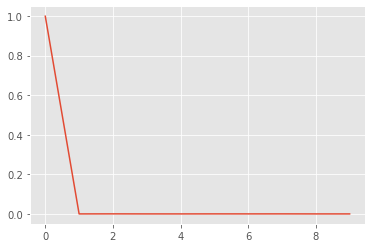

In [59]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

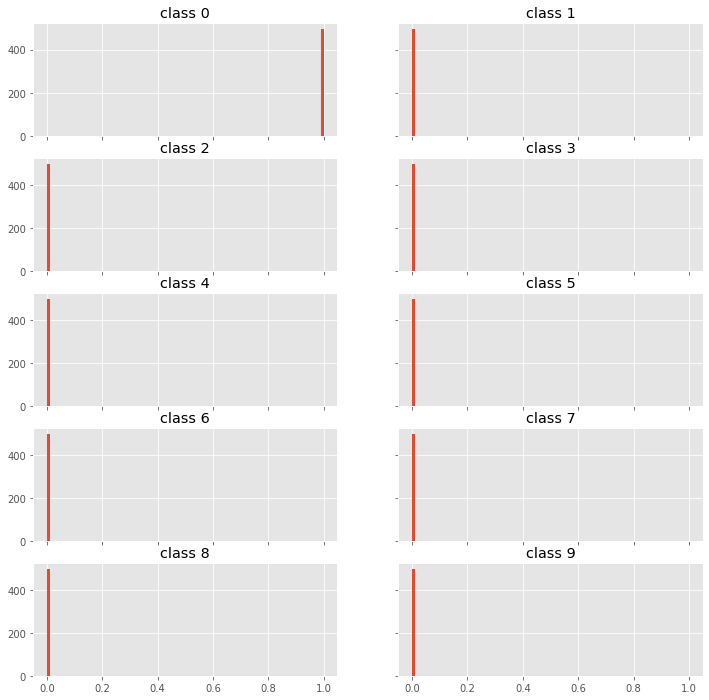

In [60]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

## Setup data augmentation

In [ ]:
from imgaug import augmenters as iaa
import random
import cv2

def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

def img_random_flip(image):
  image = cv2.flip(image, 1)  # horizontal flip
  return image

def random_augment(image):
  """50% change for each augmentation technique"""
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.0:
  # if np.random.rand() < 0.5:
    image  = img_random_flip(image)
  return image

In [ ]:
def batch_generator(images, labels, batch_size, augment):
  """Coroutine to generate batch"""
  while True:
    batch_img = []
    batch_label = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(images)-1)
      
      im = random_augment(images[random_index]) if augment else images[random_index]
      label = labels[random_index]
      
      batch_img.append(im)
      batch_label.append(label)
      
    yield(np.asarray(batch_img), np.asarray(batch_label))

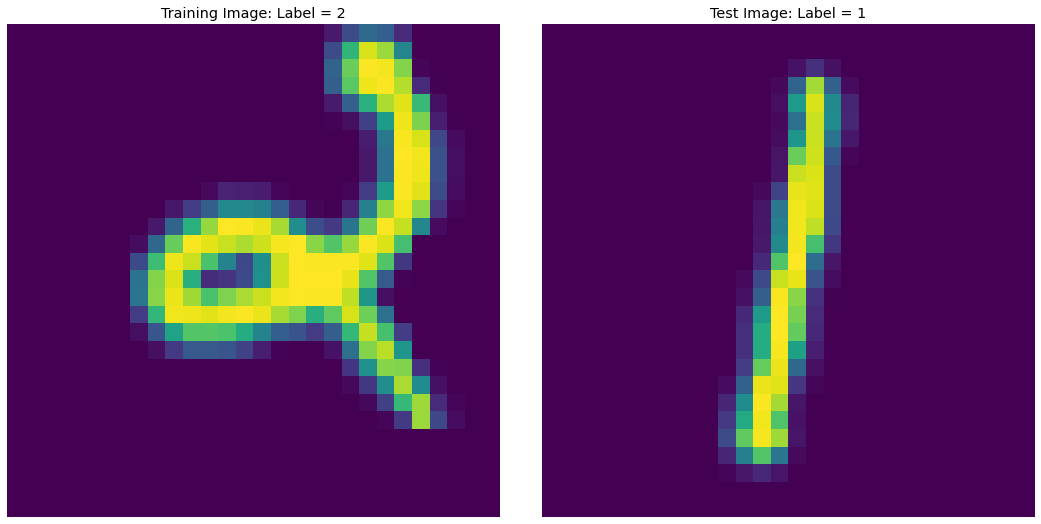

In [ ]:
## Test batch generator
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, batch_size=1, augment=True))
x_test_gen, y_test_gen = next(batch_generator(x_test, y_test, batch_size=1, augment=True))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(np.squeeze(x_train_gen[0]))
axs[0].set_title(f'Training Image: Label = {y_train_gen[0].argmax()}')

axs[1].imshow(np.squeeze(x_test_gen[0]))
axs[1].set_title(f'Test Image: Label = {y_test_gen[0].argmax()}')

axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.1,
    height_shift_range=0.1, brightness_range=[0.2, 1.2], zoom_range=[2, 3])

data_iterator = data_generator.flow(x_test, y_test, batch_size=1)

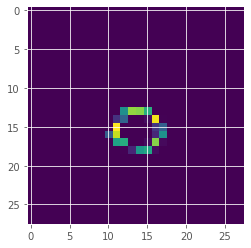

In [ ]:
batch = data_iterator.next()
plt.imshow(np.squeeze(batch[0]))

In [ ]:
score = model.evaluate(data_iterator, steps=x_test.shape[0]//10, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 195.70648193359375
Test accuracy: 0.5720000267028809


In [ ]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.200792133808136
Test accuracy: 0.9376999735832214


In [ ]:
# score of the normal model
score = model.evaluate(batch_generator(x_test, y_test, batch_size=1, augment=True), steps=x_test.shape[0]//1, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9556800723075867
Test accuracy: 0.7468000054359436


In [ ]:
# score of the normal model
score = model.evaluate(batch_generator(x_test, y_test, batch_size=1, augment=True), steps=x_test.shape[0]//1, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.985175609588623
Test accuracy: 0.7386999726295471


In [ ]:
# score of the normal model
score = model.evaluate(batch_generator(x_test, y_test, batch_size=1, augment=False), steps=x_test.shape[0]//1, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20753474533557892
Test accuracy: 0.9368000030517578


In [ ]:
# score of the normal model
score = model.evaluate_generator(batch_generator(x_test, y_test, batch_size=1, augment=False), verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.


KeyboardInterrupt: ignored

## High level plan for aleatoric uncertainty model

In [ ]:
# def get_model(mc=False, act="relu"):
#     inp = Input(input_shape)
#     x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
#     x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = get_dropout(x, p=0.25, mc=mc)
#     x = Flatten()(x)
#     x = Dense(128, activation=act)(x)
#     x = get_dropout(x, p=0.5, mc=mc)
#     out = Dense(num_classes, activation='softmax')(x)
#     # out2 = Dense(num_classes, activation='softplus')(x)  Or relu
#     # For classificiation, can either be 1 or num_classes for aleatoric uncertainty
#     # Probably num_classes, then for each prediction, looking at the sigma of the prediction
#     model = Model(inputs=inp, outputs=[out, out2])

#     model.compile(loss=keras.losses.categorical_crossentropy, # Replace with custom loss
#                   optimizer=keras.optimizers.Adadelta(),
#                   metrics=['accuracy'])
#     return model